In [1]:
# install packages

! pip3 install yahoo_fin -U
! pip3 install multiprocess
! pip3 install pyarrow


Requirement already up-to-date: yahoo_fin in c:\users\katri\anaconda3\lib\site-packages (0.8.9.1)


In [2]:
from get_historical_data import get_historical_data
from multiprocessing import Pool
from numpy.linalg import multi_dot
from sklearn.model_selection import train_test_split
from yahoo_fin import stock_info

import datetime
import itertools
import matplotlib.pyplot as plt
import numpy as np
import scipy.stats as st


# User Input Parameters

In [3]:
# desired max number of stocks to be recommended to invest in
MAX_NUM_STOCKS = 10

# length of time user plans to hold these stocks before selling
INVESTMENT_WINDOW_DAYS = 30

# end date is today. This should not be changed by the user.
END_DATE = datetime.datetime.now().date()

# start date indicating how far back to look at historical data of stocks
START_DATE = END_DATE - datetime.timedelta(days=365 * 2)


In [4]:
# get historical stock price data
def get_historical_data_batch(tickers, start_date, end_date):
    historical_data = []
    with Pool(32) as p:
        historical_data = p.map(get_historical_data, tickers)
    return historical_data

In [5]:
%%time

# pull S&P 500 ticker names from stock_info module and save in list called "tickers"
tickers = stock_info.tickers_sp500()

# if '--' is the null ticker, remove it
if '--' in tickers:
    tickers.remove('--')

# store historical stock price data
historical_data = get_historical_data_batch(tickers, START_DATE, END_DATE)


Wall time: 42.2 s


In [6]:
%%time

# get a filter for some of the historical data
ticker_to_historical_data = {ticker_table['ticker'].iloc[0]: ticker_table.sort_values('date')
                             for ticker_table in historical_data if not isinstance(ticker_table, tuple)}

# build indexes and unique dates
unique_dates = sorted(set(itertools.chain.from_iterable([table['date'] for table in ticker_to_historical_data.values()])))
unique_dates = np.array(unique_dates, dtype='datetime64[D]')
date_to_index = {date: index for index, date in enumerate(unique_dates)}

ticker_to_index = {ticker: index for index, ticker in enumerate(sorted(list(ticker_to_historical_data.keys())))}
index_to_ticker = {v: k for k, v in ticker_to_index.items()}

# initialize the data matrix to a bunch of zeros
ticker_data_matrix = np.zeros((len(tickers), len(unique_dates)), dtype=np.float)

# fill the matrix with data
for ticker, ticker_data_table in ticker_to_historical_data.items():
    ticker_index = ticker_to_index[ticker]
    ticker_dates = np.array(ticker_data_table['date'], dtype='datetime64[D]')

    date_indexes = np.array([date_to_index[cur_date] for cur_date in ticker_dates])
    price_data = ticker_data_table['close'].values
    ticker_data_matrix[ticker_index, date_indexes] = price_data

# there's some nan values in the data, write them as zero
ticker_data_matrix = np.nan_to_num(ticker_data_matrix)


Wall time: 3.57 s


In [7]:
%%time

# number of unique dates is different from the SNP 500 data.
log_price_matrix = np.copy(ticker_data_matrix)
log_price_matrix[np.where(log_price_matrix != 0)] = np.log(log_price_matrix[np.where(log_price_matrix != 0)])

# fit the log stuff with interpolation
x_values = np.array(list(range(log_price_matrix.shape[-1])))
for i, time_series in enumerate(log_price_matrix):
    mask = time_series != 0
    # if there are no non-zero values, give up
    if not np.any(mask):
        continue
    interp_x_values = x_values[mask]
    interp_y_values = time_series[mask]
    log_price_matrix[i] = np.interp(x_values, interp_x_values, interp_y_values)


Wall time: 29.1 ms


In [8]:
# calculate mean and covariance
def compute_mean_variance(start_date, end_date):
    date_diffs = log_price_matrix[:, 1:] - log_price_matrix[:, :-1]

    mean_vector = np.mean(date_diffs, axis=1)
    # Cov[XY] = E[XY] - E[X]E[Y]
    covariance_matrix = np.dot(date_diffs, date_diffs.T) / date_diffs.shape[1]
    covariance_matrix -= np.outer(mean_vector, mean_vector)

    return mean_vector, covariance_matrix

mean_vector, covariance_matrix = compute_mean_variance(START_DATE, END_DATE)

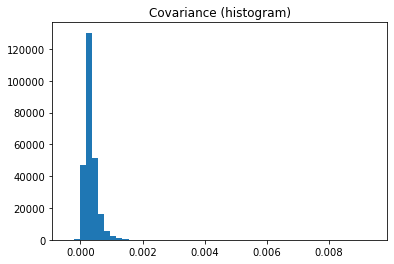

In [9]:
# plot flattened covariance array

plt.hist(covariance_matrix.flatten(), bins=50)
plt.title('Covariance (histogram)')
plt.show()

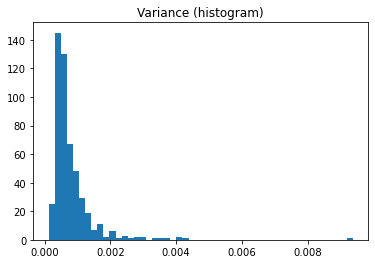

In [10]:
# variance is the diagonal of covariance matrix

plt.hist(np.diag(covariance_matrix), bins=50)
plt.title('Variance (histogram)')
plt.show()

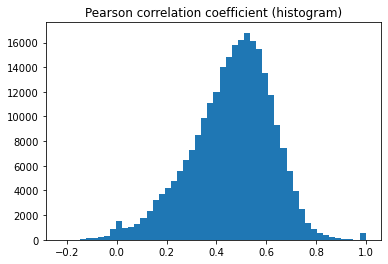

In [11]:
# calculate and plot Pearson correlation coefficient (normalized covariance)
pearsons = covariance_matrix / np.sqrt(np.outer(np.diag(covariance_matrix), np.diag(covariance_matrix)))
plt.hist(pearsons.flatten(), bins=50)
plt.title('Pearson correlation coefficient (histogram)')
plt.show()

In [12]:
# alpha is the mean
# sigma is the variance along the diagonal
# k is the covariance matrix

alpha = mean_vector * INVESTMENT_WINDOW_DAYS
sigma = np.diag(covariance_matrix) * INVESTMENT_WINDOW_DAYS
k = covariance_matrix * INVESTMENT_WINDOW_DAYS

In [13]:
# element-wise math

# square every term in alpha and sigma
alpha_element_squared = alpha * alpha
sigma_element_squared = sigma * sigma

In [14]:
# invert covariance matrix k
k_inv = np.linalg.inv(k)

# calculate r_opt using formula 3.10 from 
# https://maslov.bioengineering.illinois.edu/optimal_investment_ijtaf.pdf
r_opt = np.dot(k_inv, alpha)


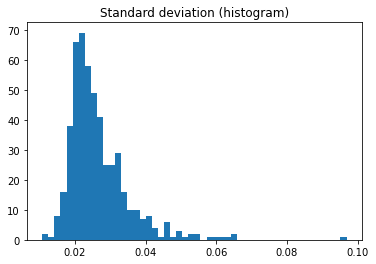

In [15]:
# square root of variance (diagonal of covariance matrix) is standard deviation

plt.hist(np.sqrt(np.diag(covariance_matrix)), bins=50)
plt.title('Standard deviation (histogram)')
plt.show()

In [16]:
# using line search to find lambda

# upper bound, we know that if lambda causes all of the terms to be zero, we went too far.
# i.e., alpha_i - upper_bound_lambda <= 0 \forall i
upper_bound_lambda = np.max(alpha)

# lower bound, we know that each term in the sum is >= 0 and <= the total sum term.
# so just find the lower bound of each term and take the maximum out of all of these terms
# for each term, lambda = alpha_i - alpha_i^2 - sigma_i^2
lower_bound_lambda = np.min(alpha - (alpha_element_squared + sigma_element_squared))

print(f"Lower bound lambda: {lower_bound_lambda}")
print(f"Upper bound lambda: {upper_bound_lambda}")

# now line search/binary search to find lambda

# first we need to evaluate the value of the summation expression in formula 3.12
# https://maslov.bioengineering.illinois.edu/optimal_investment_ijtaf.pdf

# evaluation of expression, f(lambda)
def eval_expression(lambda_value):
    # subtract one so I can get something like \sum - 1 = 0 to solve.
    fractional_terms = (alpha - lambda_value) / (alpha_element_squared + sigma_element_squared)
    
    # heavyside function
    fractional_terms = np.maximum(fractional_terms, 0)
    
    return np.sum(fractional_terms) - 1

# sanity check, the correct value (0) is between the upper bound and lower bound
print(f"Performing a check that 0 is between the evaluation of lower bound lambda ({eval_expression(lower_bound_lambda)})")
print(f"and the evaluation of upper bound lambda ({eval_expression(upper_bound_lambda)})\n")

# tolerance term
tolerance = 1e-9

# initialize our loop with our initial guess for our line search
lower_lambda = lower_bound_lambda
upper_lambda = upper_bound_lambda
middle_lambda = (lower_bound_lambda + upper_bound_lambda) / 2

iterations = 0

while np.abs(eval_expression(middle_lambda)) > tolerance:
    # evaluate the expression with updated lambda
    middle_value = eval_expression(middle_lambda)
    
    # if eval of expression (middle_value) is > 0, then lambda guess is too small.
    # Middle lambda becomes new lower lambda.
    if middle_value > 0:
        lower_lambda = middle_lambda
    # else, lambda guess is too large. Middle lambda becomes new upper lambda.
    else:
        upper_lambda = middle_lambda
        
    # new middle lambda is halfway between lower and upper lambda
    middle_lambda = (lower_lambda + upper_lambda) / 2

    iterations += 1
    print_message = f'''
Iteration: {iterations}
Lambda: {middle_lambda}
Evaluation of expression: {eval_expression(middle_lambda)}
'''
    print(print_message)


Lower bound lambda: -0.06008076866789784
Upper bound lambda: 0.1955717055382371
Performing a check that 0 is between the evaluation of lower bound lambda (66322.42172254875)
and the evaluation of upper bound lambda (-1.0)


Iteration: 1
Lambda: 0.13165858698670335
Evaluation of expression: 1.5743419948290396


Iteration: 2
Lambda: 0.16361514626247023
Evaluation of expression: -0.29668371898521817


Iteration: 3
Lambda: 0.1476368666245868
Evaluation of expression: 0.5499576638891663


Iteration: 4
Lambda: 0.15562600644352853
Evaluation of expression: 0.11242916969556194


Iteration: 5
Lambda: 0.15962057635299937
Evaluation of expression: -0.10633507740123882


Iteration: 6
Lambda: 0.15762329139826395
Evaluation of expression: 0.0030470461471614474


Iteration: 7
Lambda: 0.15862193387563167
Evaluation of expression: -0.05164401562703935


Iteration: 8
Lambda: 0.15812261263694782
Evaluation of expression: -0.024298484739939674


Iteration: 9
Lambda: 0.15787295201760587
Evaluation of expre

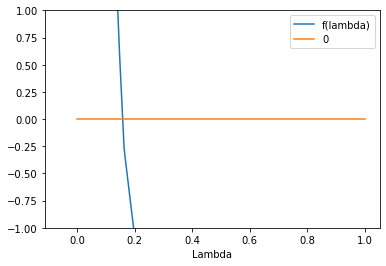

In [17]:
# plot to confirm correct lambda value
# intersection of 0 and f(lambda) indicates correct lambda value

# 101 evenly spaced points between lower bound lambda and upper bound lambda
x = np.linspace(lower_bound_lambda, upper_bound_lambda, 101)

# evaluate each of these 101 points and plot them, f(lambda)
plt.plot(x, [eval_expression(el) for el in x], label='f(lambda)')

# plot 0
plt.plot([0, 1], [0, 0], label='0')

plt.legend()
plt.xlabel('Lambda')
plt.ylim([-1,1])

plt.show()

# Final Output

In [18]:
# get the optimal investment portfolio. Formula 3.11
r_opt = np.maximum(0, (alpha - middle_lambda) / (alpha_element_squared + sigma_element_squared))

# flatten r_opt array. Collapse into one dimension.
r_opt = r_opt.flatten()

# store indices of best stocks (stocks with largest recommended investment portions)
best_stock_indices = np.argsort(-r_opt)[:MAX_NUM_STOCKS]

# use the best stock indices to pull the recommend investment portions of these best stocks
best_stock_prices = r_opt[best_stock_indices]

# normalize best stock proportions so they add up to 1
best_stock_prices /= np.sum(best_stock_prices)

# create an array with each best stock ticker listed with the corresponding investment portion
r_opt_top_stocks_with_names = []
for best_stock_price, best_stock_index in zip(best_stock_prices, best_stock_indices):
    r_opt_top_stocks_with_names.append([best_stock_price, index_to_ticker[best_stock_index]])

print ('\033[1m' + '\033[4m' + 'Suggested investment proportions')
r_opt_top_stocks_with_names


Suggested investment proportions


[[0.8339635704639179, 'MRNA'],
 [0.16603642953608205, 'TSLA'],
 [0.0, 'NWL'],
 [0.0, 'NVR'],
 [0.0, 'NVDA'],
 [0.0, 'NUE'],
 [0.0, 'NTRS'],
 [0.0, 'NTAP'],
 [0.0, 'NSC'],
 [0.0, 'NRG']]

In [19]:
# calculate mean, variance, and standard deviation of expected return
expected_val = np.dot(r_opt, alpha)
variance = multi_dot([r_opt.T, covariance_matrix, r_opt])
standard_dev = np.sqrt(variance)

expected_return_percent = np.round(100 * (np.exp(expected_val) - 1), 2)

print(f"Mean/expected total return: {expected_val} ({expected_return_percent}%)")
print("Variance: ", variance)
print("Standard dev: ", standard_dev, "\n")

# Calculating confidence intervals:
# https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.zscore.html

for confidence_level in [0.99, 0.95, 0.85]:
    error = abs(st.norm.ppf((1-confidence_level)/2)) * standard_dev
    print(f"{confidence_level * 100}% confidence interval: {expected_val}", u"\u00B1", error)
    
    lower_bound_percent = np.round(100 * (np.exp(expected_val - error) - 1), 2)
    upper_bound_percent = np.round(100 * (np.exp(expected_val + error) - 1), 2)
    print(f"Expected investment return: {lower_bound_percent}% - {upper_bound_percent}%\n")


Mean/expected total return: 0.190121721156131 (20.94%)
Variance:  0.0020762250098369946
Standard dev:  0.04556561214158101 

99.0% confidence interval: 0.190121721156131 ± 0.11736923898842792
Expected investment return: 7.55% - 36.0%

95.0% confidence interval: 0.190121721156131 ± 0.08930695873101978
Expected investment return: 10.61% - 32.24%

85.0% confidence interval: 0.190121721156131 ± 0.06559313267038126
Expected investment return: 13.26% - 29.14%

